In [1]:
import os
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import (ANIMALS, _BRAIN_AREAS, PROCESSED_DATA_DIR, TRANSITION_TO_CATEGORY)
from src.load_data import load_data
from src.visualization import plot_1D_results

In [2]:
epoch_key = "bon", 4, 2
data = load_data(epoch_key)


Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


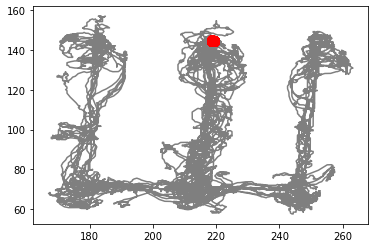

In [4]:
position_1D = data["position_info"].loc[:, "linear_position"]
position_2D = data["position_info"].loc[:, ["x_position", "y_position"]]

ripple_number = 106
ripple_start, ripple_end = (
    data["ripple_times"].loc[ripple_number].start_time,
    data["ripple_times"].loc[ripple_number].end_time,
)

ripple_position_info = data["position_info"].loc[ripple_start:ripple_end]

import matplotlib.pyplot as plt
plt.plot(position_2D.x_position, position_2D.y_position, color="black", alpha=0.5)
plt.plot(
    ripple_position_info.x_position,
    ripple_position_info.y_position,
    color="red",
    marker="o",
    markersize=10,
)

In [48]:
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_spikes_dataframe,
    make_neuron_dataframe,
)

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = neuron_info.loc[
    (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
    & (neuron_info.type == "principal")
]

spike_times = [
    get_spikes_dataframe(neuron_key, ANIMALS) for neuron_key in neuron_info.index
]

In [36]:
animal, day, epoch = epoch_key
data_type, dim = "sorted_spikes", "1D"
model_name = os.path.join(
    PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
)
print(model_name)
classifier = SortedSpikesClassifier.load_model(model_name)

time_slice = slice(ripple_start, ripple_end)
s = data["spikes"].loc[time_slice]
sorted_spikes_results_1D = classifier.predict(
    s, time=s.index - s.index[0]
)

/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/bon_04_02_sorted_spikes_1D_model.pkl


In [44]:
sorted_spikes_results_1D = sorted_spikes_results_1D.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)


In [49]:
from src.analysis import get_place_field_max

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

ordered_spike_times = [spike_times[i] for i in linear_position_order]

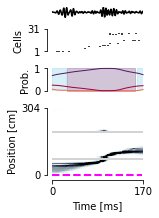

In [51]:
import os

from src.visualization import plot_1D_results
from src.parameters import FIGURE_DIR
from src.figure_utilities import save_figure

plot_1D_results(
    ordered_spike_times,
    data,
    sorted_spikes_results_1D,
    classifier,
    ripple_number,
    data_type="sorted_spikes",
)

fig_name = (
    "figure2_"
    f"{animal}_{day:02d}_{epoch:02d}_{ripple_number:04d}_"
    f"sorted_spikes_1D_acasual_classification"
)
#save_figure(os.path.join(FIGURE_DIR, "Figure2", fig_name))

In [64]:
import numpy as np
MILLISECONDS_TO_SECONDS = 1000
time = MILLISECONDS_TO_SECONDS * sorted_spikes_results_1D.time / np.timedelta64(1, "s")


In [69]:
sorted_spikes_results_1D.assign_coords(time=time).acausal_posterior.sum("state").where(classifier.is_track_interior_)

<xarray.DataArray 'acausal_posterior' (time: 85, position: 95)>
array([[0.00347416, 0.00548422, 0.01046976, ..., 0.00183953, 0.00159477,
        0.00117888],
       [0.00257505, 0.00438587, 0.00929618, ..., 0.00176868, 0.00150746,
        0.00106645],
       [0.00179379, 0.00323171, 0.00782264, ..., 0.00170713, 0.00142151,
        0.00093844],
       ...,
       [0.00039034, 0.00038559, 0.00038276, ..., 0.00037474, 0.00037742,
        0.00038471],
       [0.0005109 , 0.00050466, 0.00050092, ..., 0.00049037, 0.00049391,
        0.00050348],
       [0.00062362, 0.00061606, 0.00061153, ..., 0.00059876, 0.00060304,
        0.00061462]])
Coordinates:
  * time      (time) float64 0.0 2.0 4.0 6.0 8.0 ... 162.0 164.0 166.0 168.0
  * position  (position) float64 1.483 4.449 7.415 10.38 ... 296.5 299.5 302.5

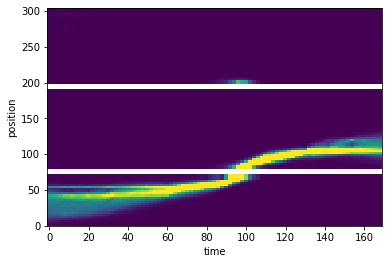

In [72]:
sorted_spikes_results_1D.assign_coords(time=time).acausal_posterior.sum("state").where(classifier.is_track_interior_).plot(
            x="time",
            y="position",
            robust=True,
            add_colorbar=False,
            zorder=0,
            rasterized=True,
        )